In [1]:
import datetime
import gc
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as f1_score
import lightgbm as lgb

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from preprocessing import load_messages, translit

### Загузка и предварительная очитка данных
Для исследования мы испоьзовали сведий дамп слака ODS от 06 марта 2021 года.<br>
Каналы jobs и jobs hr. Загрузим сообщения в pandas df и очистим от лишний информации.

In [2]:
messages = load_messages('jobs', 'jobs_hr')

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '_jobs'

### Кол-во сообщений

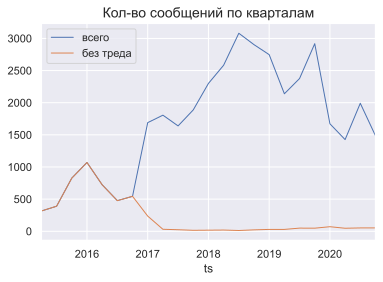

In [4]:
messages[].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                          label='всего')
messages[messages.thread_ts.isna()].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                     label='без треда')
plt.legend()
plt.title('Кол-во сообщений по кварталам', size=14)
plt.show()

Общее кол-во сообщений достигло <b>максимума в 3 квартале 2018 года</b>.<br>
После этого активность снижалась - резкое <b>падение активности произошло в 2020 году</b>

#### Что это кронокризис или хайп по data science уже прошел?

Здесь мы смотрим на все сообщения - это и сами вакансии и комментарии пользователей.<br>
До 2017 года тредов вообще не было и все сообщения сыпались в общий канал.<br>
У части сообщений и сейчас нет треда - если никто не оставил комментарий.<br>

Для дальнейшего анализа нам нужно отделать сообщения с вакансиями от комментариев пользователей.<br>
Самый простой подход - это считать вакансией все сообщения с котрых начинается тред (thread_ts = ts).<br>
Но тогда мы потеряем всю статистику за 2015-2016 года.<p>
    
Второй вариант - это обучить простую модель на этой метке и разделить с ее помошбю сообщения без треда.<br>

### Классификация сообщений на вакансии и комментарии

В качесстве признаков будет использовать count по всем словам в сообщении и дополнительную метаинформацию:
<li> lines_count - кол-во энтеров в сообщении
<li> words_count - кол-во слов в сообщении
<li> words_per_line - среднее кол-во слов на строчку    
<li> is_reply - 1 если в сообщении тегнут другой пользователь, иначе 0
<li> seconds_since_last_message - кол-во секунд с последнего сообщения этого пользователя
<li> seconds_to_next_message - кол-во секунд до следующего сообщения этого пользователя
<li> message_number_for_user - порядковый номер сообщения для пользователя
<li> message_count_for_user - кол-во сообщений у пользователя

In [5]:
# CountVectorizer для текста
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(messages['text'])
word_cols = countvectorizer.get_feature_names()
word_cols = ['_' + translit(col) for col in word_cols]

# Добавлеям колонки с count по словам
messages = pd.concat((messages, pd.DataFrame(countvectorizer.transform(messages['text']).toarray(), 
                                 columns=word_cols)), axis=1)

# Делим на трейн и тест и обучаем модель
df = messages[~messages['thread_ts'].isna()].reset_index(drop=True)
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, word_cols], df['is_job'],
                                                    test_size = 0.33, random_state = 555)
gbm1 = lgb.LGBMClassifier(num_leaves=7, n_estimators=200, feature_fraction=0.3, bagging_fraction=0.5)
gbm1.fit(X_train, y_train)

# Помечяем вакансии новой моделью
messages['is_job'] = gbm1.predict(messages.loc[:, word_cols])
messages = messages.loc[:,[i for i in messages.columns if i not in word_cols]]

del X_train, y_train, df
gc.collect()

3553

#### Качество модели
<p>Качества этой простой модели более чем достаточно для поставленной задачи.<br>
Тем более, что разметка для обучения шумная и не на 100% точная.<p>

In [6]:
# Считаем метрики
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy для наивной модели {accuracy_baseline}')
pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy для модели {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

# Accuracy для наивной модели 93.5
# Accuracy для модели 99.6
# F1 score 0.9693165969316597

Accuracy для наивной модели 93.5
Accuracy для модели 99.6
F1 score 0.9651810584958218


#### Важность признаков
По важности фич нет, ничего необычного 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


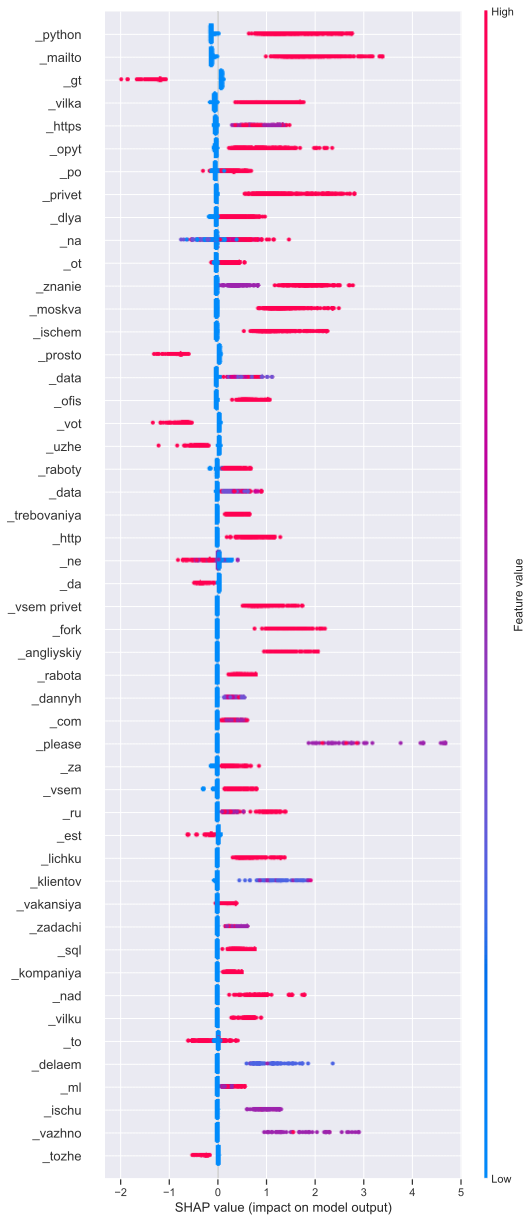

In [7]:
# Нарисуем шап для модели
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=50)

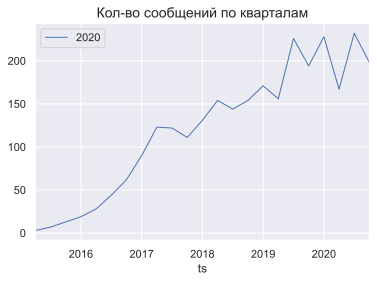

In [12]:
messages[(messages.is_job==1)].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                          label='2020')
plt.legend()
plt.title('Кол-во сообщений по кварталам', size=14)
plt.show()

Треды появились только после 2016-09-28 00:00:00


In [11]:
messages[messages['thread_ts'] < '2017-01-01']

ts       user  \
5099  2016-09-28 02:41:11  U0ZH1ACES   
18026 2018-01-27 11:38:14  U0UJ0DYH4   

                                                    text  \
5099   Всем привет! Сейчас возникла задача, связанная...   
18026                        Нам нужна ветка Сологубов.    

                                            user_profile attachments edited  \
5099   {'avatar_hash': 'c1b963fe4355', 'image_72': 'h...         NaN    NaN   
18026  {'avatar_hash': 'feccc2e10e9c', 'image_72': 'h...         NaN    NaN   

                                               reactions           thread_ts  \
5099   [{'name': 'fork_and_knife', 'users': ['U0ZHHV8... 2016-09-28 02:41:11   
18026                                                NaN 2016-09-28 02:41:11   

       reply_count  reply_users_count  ...  reply_users  \
5099           1.0                1.0  ...  [U0UJ0DYH4]   
18026          NaN                NaN  ...          NaN   

                                                 replies subscribed  \
5099   [{'user': 'U0UJ0DYH4', 'ts': '1517042294.00005...      False   
18026                                                NaN        NaN   

      parent_user_id last_read client_msg_id blocks old_name name source  
5099             NaN       NaN           NaN    NaN      NaN  NaN   jobs  
18026      U0ZH1ACES       NaN           NaN    NaN      NaN  NaN   jobs  

[2 rows x 21 columns]

In [1049]:

    




def preprocessing(data):
    data['text_lower'] = data['text'].str.lower()
    data['ts_conv'] = (data['ts'].astype('float')).apply(convert_ts)
    data['thread_ts_conv'] = (data['thread_ts'].astype('float')).apply(convert_ts)
    data['symbols_len'] = data['text_lower'].str.len()
    data['words_len'] = (data['text_lower'].apply(word_tokenize)).str.len()
    data['lines_len'] = (data['text_lower'].str.split("\n")).str.len()
    data['ts_hour'] = data['ts_conv'].dt.hour
    data['ts_weekday'] = data['ts_conv'].dt.weekday
    data['ts_weekday'] = data['ts_conv'].dt.weekday
    data['messages_count_user'] = data.groupby('user')['user'].transform('count')
    data['message_number_user'] = data.groupby('user').cumcount() + 1
    data['seconds_since_last_message'] = (data['ts_conv'] - data.groupby('user')['ts_conv'].shift(1)).dt.total_seconds()
    data['seconds_to_next_message'] = (data.groupby('user')['ts_conv'].shift(-1) - data['ts_conv']).dt.total_seconds()
    data['is_reply'] = data['text_lower'].str[:2] == '<@'
    data['have_attachments'] = np.where(data.attachments.isna(), 0, 1)
    
#     всем привет

In [3]:
messages = load_clean_messages()

NameError: name 'load_clean_messages' is not defined

In [3]:
messages.ts

2       2015-04-14 14:20:20
3       2015-04-14 14:21:08
21      2015-04-14 21:39:59
22      2015-04-14 22:40:26
23      2015-04-14 22:41:35
                ...        
45801   2020-11-18 15:03:51
45802   2020-11-18 15:21:09
45803   2020-11-18 15:50:26
45804   2020-11-18 18:23:11
45806   2020-11-26 13:52:49
Name: ts, Length: 38991, dtype: datetime64[ns]

In [2]:
def convert_ts(ts):
    if isinstance(ts, float) and ts == ts and ts is not None:
        return datetime.datetime.fromtimestamp(ts)
    else:
        return None


(messages['ts'].astype('float')).apply(convert_ts).dt.round('s')

NameError: name 'messages' is not defined

In [1069]:
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('russian') )
# vectorizer = TfidfVectorizer(stop_words=stopwords)
# tfidf_matrix = vectorizer.fit_transform(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\egorb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [1144]:
# Убираем слишком короткие предложения, которые априори не могут быть вакансиями
metainfo_cols = ['ts_hour', 'ts_weekday', 'messages_count_user', 'is_reply', 'words_len', 'have_attachments',
                 'message_number_user', 'seconds_since_last_message', 'seconds_to_next_message', 'lines_len',
                 'privet', 'need', 'need_plus', 'position']


select = (messages.symbols_len >= 100) & (messages.words_len > 20)
df = messages[select].reset_index(drop=True)
with_target = ~df.thread_ts.isna()

text_transformer = TfidfVectorizer(ngram_range=(1, 3), max_features=8000,
                                    stop_words=stopwords)
tfidf = text_transformer.fit(df['text_lower'])
tfidf_cols = text_transformer.get_feature_names()

df['chel_feature'] = np.where(df['thread_ts'] == df['ts'], 1, 0)
df = df.loc[:,['chel_feature', 'text_lower'] + metainfo_cols]

# df = pd.concat((df, pd.DataFrame(tfidf.toarray(), columns=tfidf_cols)), axis=1)

# no_target = df[~with_target]

cols = tfidf_cols
train, test = train_test_split(df[with_target], test_size=0.33, random_state=555)
train_tfidf = tfidf.transform(train['text_lower'])
test_tfidf = tfidf.transform(test['text_lower'])

In [997]:
reactions_dict = {}
for reactions in messages['reactions']:
    if isinstance(reactions, list):
        for reaction in reactions:
            name = reaction.get('name')
            if reactions_dict.get(name):
                reactions_dict[name] += reaction['count']
            else:
                reactions_dict[name] = reaction['count']

In [999]:
len(reactions_dict)

1740

In [1145]:
gbm1 = lgb.LGBMClassifier(num_leaves=11, n_estimators=1500, feature_fraction=0.3, bagging_fraction=0.3, learning_rate=0.01)
gbm1.fit(train_tfidf, train.chel_feature)

LGBMClassifier(bagging_fraction=0.3, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.3,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1500, n_jobs=-1, num_leaves=11, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [1081]:
lg = LogisticRegression(max_iter=500)
lg.fit(train.loc[:,cols], train.chel_feature)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [1024]:
sv = svm.SVC(kernel='linear', C=1.0)
sv.fit(train.loc[:,cols], train.chel_feature)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [58]:
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


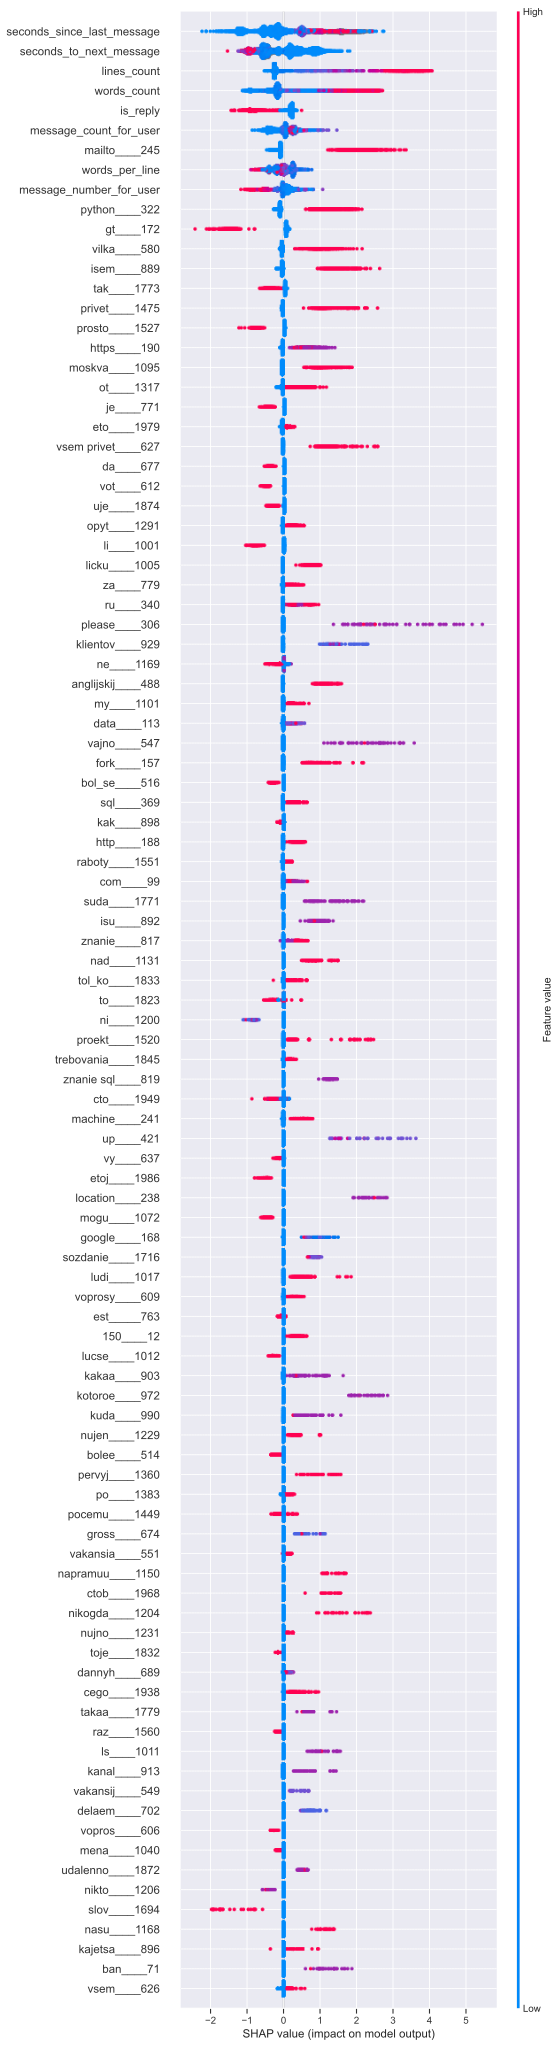

In [1151]:
test['pred'] = gbm1.predict_proba(test_tfidf)[:,1]
# train['pred'] = sv.predict(train.loc[:,cols])
# no_target['pred'] = sv.predict(no_target.loc[:,cols])

In [1147]:
AUC(test['chel_feature'], test['pred'])

0.9969239219994507

In [1135]:
pd.DataFrame(zip(cols, gbm1.feature_importances_)).sort_values(by=1, ascending=False).iloc[30:60]

0   1
1843            всем  76
4014    разработчика  74
286              com  74
2560        компанию  74
2030          делаем  72
353             data  70
3206          оплата  69
2836             млн  69
1389          vision  69
2461          канала  66
4672           треде  66
2516        клиентов  66
2575  кому интересно  65
4370        создание  64
4919             чат  64
730            keras  64
3469          плюсом  63
1081          remote  61
3626      построение  59
1429        with the  58
3221            опыт  57
1687        вакансия  57
1085    requirements  56
2197          задачи  56
3128      обсуждения  56
4155          рублей  55
3353           офисе  54
3127      обсуждение  54
989           please  53
1873           вывод  53

In [1159]:
test[test['pred'] > 0.01][test.chel_feature == 0]

Boolean Series key will be reindexed to match DataFrame index.


chel_feature                                         text_lower  \
11234             0  а не проще сетку сделать для сегментации на те...   
8247              0  <@u90hkuw3b> нужно уточнить: 1. на частичный г...   
4053              0  in other words:\n·    architecting complex sol...   
6720              0  это похоже на правду.\nплюс небольшое дополнен...   
13567             0  <@u5r820kh6>\n1. online coding challenge test ...   
...             ...                                                ...   
4340              0  "основные акционеры группы «сибур холдинг» — м...   
1931              0  <@u4bb42ksm> смотря что его мотивирует в долго...   
6998              0  science-наука. основой этой деятельности являе...   
6500              0  <@u6qp7gd7w>, <@u7nu75ad6> давайте так, все ди...   
2919              0  <https://opendatascience.slack.com/archives/c0...   

       ts_hour  ts_weekday  messages_count_user  is_reply  words_len  \
11234       15           4                   28     False         45   
8247        11           4                   89      True         57   
4053        20           1                  361     False        246   
6720        10           1                   36     False         25   
13567       19           0                   24      True         94   
...        ...         ...                  ...       ...        ...   
4340        18           5                  201     False         52   
1931        12           1                   15      True         76   
6998        13           2                   65     False         50   
6500        14           2                  128      True         64   
2919        14           3                  118     False        106   

       have_attachments  message_number_user  seconds_since_last_message  \
11234                 0                   10                 2378.012600   
8247                  0                   37               250192.570900   
4053                  0                   94                    9.999861   
6720                  0                   14                42247.000000   
13567                 0                   21                 2313.002500   
...                 ...                  ...                         ...   
4340                  0                    1                         NaN   
1931                  0                    2                 6292.500334   
6998                  0                    6                   85.000400   
6500                  0                   71                 3489.000000   
2919                  1                   59                83334.999919   

       seconds_to_next_message  lines_len  privet   need  need_plus  position  \
11234             1.556700e+06          1   False  False      False     False   
8247              2.486381e+05          1   False  False      False     False   
4053              1.321000e+03         19   False  False      False     False   
6720              1.633100e+04          3   False  False      False     False   
13567             1.040005e+02          6   False  False      False     False   
...                        ...        ...     ...    ...        ...       ...   
4340              7.399999e+01          2   False  False      False     False   
1931              4.464085e+03          1   False  False      False     False   
6998              2.600020e+01          1   False  False      False     False   
6500              1.000950e+05          1   False  False      False     False   
2919              1.081400e+04          1   False  False      False     False   

           pred  
11234  0.011866  
8247   0.015590  
4053   0.048064  
6720   0.011556  
13567  0.022188  
...         ...  
4340   0.014790  
1931   0.010838  
6998   0.010238  
6500   0.091443  
2919   0.037756  

[148 rows x 17 columns]

In [1092]:
test.loc[5283, 'text_lower']

'мы снова расширяемся, нам нужен еще один аналитик в команду.\nс точки зрения задач, примерно 50/50 это аналитика и дс задачи. придется и дашборды покрутить и факторы ранжирования обучать, и задачи на dl попробовать.\nв общем, можно писать мне, через общую форму или ceo геосервисов :slightly_smiling_face: \n\ngeo is :fireball: \n<https://www.facebook.com/roman.chernin/posts/10209628210381160>'

In [874]:
train[train['text_lower'].str.contains('админов ods')]

chel_feature                                         text_lower  \
8514             1  всем привет, сообщество админов ods совместно ...   

      symbols_len  words_len  lines_len  ts_hour  ts_weekday  \
8514          361         64          2       12           2   

      messages_count_user  message_number_user  seconds_since_last_message  \
8514                  361                  178                  77363.0539   

      ...  youll  yousician  youtu  youtube  youtube com  youtube com watch  \
8514  ...    0.0        0.0    0.0      0.0          0.0                0.0   

      zalando  zeppelin  zyfra  pred  
8514      0.0       0.0    0.0     0  

[1 rows x 2012 columns]

In [561]:
words_dict = {}
for text in tqdm_notebook(messages['text_clear']):
    text = word_tokenize(text)
    text_dict = {}
    for word in text:
        if text_dict.get(word):
            text_dict[word][1] += 1
        else:
            text_dict[word] = [1, 1]
    for key, value in text_dict.items():
        if words_dict.get(key):
            words_dict[key][0] += text_dict[key][0]
            words_dict[key][1] += text_dict[key][1]
        else:
            words_dict[key] = [0, 0]
            words_dict[key][0] = text_dict[key][0]
            words_dict[key][1] = text_dict[key][1]

In [590]:
for i in words_dict_50:
    

['ищет',
 'data',
 'scientist',
 "'",
 'a',
 ':',
 '<',
 'http',
 '>',
 'вот',
 'контакты',
 'человека',
 ',',
 'которому',
 'можно',
 'писать',
 'напрямую',
 'mailto',
 '@',
 'gmail.com',
 '.',
 'такой',
 'вопрос',
 'по',
 '-',
 'всё',
 'что',
 'я',
 'видел',
 'с',
 'анализом',
 'данных',
 'обязательно',
 'наличие',
 'как',
 'минимум',
 'опыта',
 'работы',
 'в',
 'этой',
 'сфере',
 'где',
 'взять',
 'опыт',
 'особенно',
 'для',
 'если',
 'только',
 'за',
 '?',
 'к',
 '(',
 'из',
 'почта',
 'выше',
 ')',
 'он',
 'сказал',
 'даже',
 'могут',
 'рассмотреть',
 'конечно',
 'на',
 'другие',
 'вакансии',
 'но',
 'а',
 'самом',
 'деле',
 'могу',
 'рынок',
 'специалистов',
 'мало',
 'потому',
 'некоторые',
 'готовы',
 'брать',
 'что-то',
 'и',
 '“',
 "''",
 'о',
 'надо',
 'делать',
 'есть',
 'ли',
 'сейчас',
 'у',
 'них',
 'довольно',
 'задание',
 'анализ',
 'спасибо',
 '!',
 'тоже',
 'опытом',
 '50',
 'аналитиков',
 '&',
 'gt',
 ';',
 'высшее',
 'образование',
 'техническое',
 'навыки',
 'ана

In [585]:
count = 0
for key, value in words_dict.items():
    if value[0]>50:
        count += 1

In [586]:
count

1394

In [508]:
'\n2 deae'.replace(r'\n', '')


'\n2 deae'

In [467]:
data = messages.copy()
text_step = data.text_lower
text_step = text_step.str.replace('headhunter', '')
data['head'] = text_step.str.contains('head')

In [472]:
for i, row in data[data['head']].iterrows():
    print(row['text'])
    print('\n\n\n')

Head of Business Intelligence &amp; Analytics (3 subordinates)
Responsibilities:
Set individual and team targets and measure attainment
Manage the team workflow and priorities and distribute the tasks
Provide reporting to management and serviced business units
Requirements: 
Degree in economics, business administration, mathematics/statistics or IT/engineering
At least four years of relevant work experience in online advertising or ecommerce
Fluent in both Russian and English 
Excel and VBA 
Solid technical skills regarding query design in SQL, ideally you have worked with R, tableau and Hadoop/hive




Есть вакансия: "Head of Research and Analytics" в digital-агентство группы BBDO (Proximity Media). Москва, м. Павелецкая / Пролетарская
full-time, полностью исследовательская работа + немного разработки, один подчиненный.
Задачи:
- Глубокий анализ медийных рекламных кампаний в рунете (никто по-настоящему не знает, кто сколько тратит на интернет-маркетинг и как размещается. Надо научить 

<mailto:afonina@hipoheads.com|afonina@hipoheads.com>




Всем привет. Меня зовут Сергей, я работаю в Lamoda, отвечаю за аналитику и планирование продаж. В нашу продуктовую команду Research&amp;Development (R&amp;D) мы ищем руководителя группы машинного обучения. У нас матричная структура и эта позиция находится в прямом подчинении у <@U06LWKFMM> (Head of R&amp;D) и меня.

В двух словах о компании - мы один из самых больших интернет-магазинов одежды, обуви и аксуссуаров в СНГ. Сотни тысяч товаров, на сайте ежедневно порядка 1.5 млн посетителей. Всего в компании (включая операции) 5к сотрудников, &gt;200 человек в IT, &gt;60 аналитиков, в компании очень развита data driven культура. Развитие внутренней экспертизы по машинному обучению для нас является приоритетом и мы будем активно инвестировать в это направление в течение ближайших лет.

*R&amp;D Machine Learning Team Lead*

Функционал:
 - Руководить командой (сейчас 4 человека), которая отвечает за data science в таких проектах как рек

• Cozy office (5min walk from Dmitrovskaya metro station), coffee, fruits, snacks and free lunches




Всем привет! По мимо руководителя отдела (на прошлой неделе выкладывал) еще ищу дата аналитика в Wheely (<https://wheely.com/>) в Москве. Вилка 100-150k. Резюме или вопросы пишите мне в личку или по адресу: <mailto:anton@wheely.com|anton@wheely.com>

Wheely is the #1 executive class service in Russia, with the ambition to become the #1 business and lux class private driver service in London in 2018. We are looking for a data analyst reporting to the head of analytics (currently hiring).

*You will be responsible for:*
• Drawing out business insights from data and presenting finding and recommendations
• Creating, maintaining &amp; documenting reports in our BI tool
• Teaching stakeholders how to use our tools &amp; reports

Our present stack is Periscope Data + Redshift and we are considering moving to Mode.
Interview mode: 1 Interview + Test Assignment (<https://docs.google.com/docum

Фриланс и парт-тайм нет. Требования, условия и плюшки не являются исчерпывающими. Другими словами, если чувствуете в себе силы, пишите скорее в личку тут или t.me/slavasmirnov




Всем привет! 
В Корпоративном бизнесе ПАО Сбербанк в Санкт-Петербурге мы создаем команду по разработке моделей планирования и управления эффективностью продаж  – требуются Data Scientistы (все уровни включая Лида).
Вам предстоит работа в команде, где будут методологи, аналитики, разработчики, инженеры. Команда занимается анализом транзакционных данных, гео-данных, финансовых и разнообразных внешних данных.  Как мы ранее описывали, у Сбербанка есть ряд особенностей:
1.	Возможность поработать с действительно богатыми и интересными данными (видим весь рынок, много данных закупаем).
2.	Возможность быть частью быстрорастущего DS сообщества Сбера.
3.	Возможность писать на современном стеке (Python + Spark) и проникнуться всеми нюансами работы в большой технологической компании.
Предстоят следующие задачи:
•	Построе

<mailto:mariia.shramko@gmail.com|mariia.shramko@gmail.com>




:flag-fr: :flag-fr: :flag-fr: :flag-fr: :flag-fr:
Вакансии - (Senior) Machine Learning Engineer в Criteo Head Quarters в Париже

Кратко о Criteo:
    - Одна из крупнейший компаний в мире, занимающихся интернет-рекламой. 2500 сотрудников (600 - в R&amp;D, 50 связаны с machine learning)
    - Крупнейший частный hadoop-кластер в Европе (пруфлинк - <http://www.cloudcomputingintelligence.com/case-study/item/2478-criteo-creates-biggest-european-private-hadoop-cluster-with-huawei>)
    - Оценка на Glassdoor 4.1 - <https://www.glassdoor.com/Reviews/Criteo-Reviews-E426672.htm>

- Задачи:
    - Разработка на Scala (Spark) и Python (TensorFlow)
    - Улучшение существующих моделей (тюнинг, новые фичи, AB-тесты и т.д.)
    - Внедрение моделей в области, где их пока нет
    - Внедрение новых моделей на TensorFlow
    - Разработка внутренних инструментов ML (у нас свой MLLib на Spark)
    - Типы используемых ML-алгоритмов / методов - лин

Писать мне, единственное что в слаке сообщения теряются довольно быстро, можно попинговать в телеграме




Всем привет, как вы возможно помните недавно я поднялся по карьерной лестнице в Х5 и стал начальником управления развитиях данных в дирекции больших данных, по английски  должность звучит все также, Head of Data Science. В рамках управления есть отдел машинного обучения, отдел анализа данных, группа R&amp;D и создается отдел компьютерного зрения.
В целом у нас есть 8 продуктовых направлений (видимо скоро будет больше) и люди раскиданы по ним (например предсказание спроса - 104 млн товаров в неделю или модели аплифта/лояльность), но постоянно возникают какие то задачи со сторон, которые нужно искать, поэтому мне нужны два человека которые пойдут прямо ко мне, решать неожиданно возникающие задачи без конкретного продукта. От ребят нужен Python, SQl, матстат, желательно spark
Нужны более менее крепкие ребята, 2 вакансии деньги следующие 180 + 36 и 220 + 44, все цифры гросс, цифра пос

• Amazing problem solving abilities.




*Update* to вакансии Head of Data Science в <http://Ostrovok.ru|Ostrovok.ru>
Прошло полтора месяца поисков, мы лучше поняли, кого хотим видеть свим коллегой, поэтому решили изменить вилку: *250-400к net + опционы*.
Разброс стал больше, поскольку мы будем рады пообщаться как с опытными DS, но без большого стажа управления командой, так и с экспертами, имевщими обширный опыт руководства.

Связаться, как и раньше, можно по почте <mailto:e.shneyderman@ostrovok.ru|e.shneyderman@ostrovok.ru>, в личку (но могу ответить не сразу), либо откликнуться <https://hh.ru/vacancy/27723418>
Дублирую описание вакансии с парой правок ниже.
----------------------
Привет. Мы, в <http://Ostrovok.ru|Ostrovok.ru> :desert_island:, ищем руководителя в команду Data Science.
Офис в Москве, full time + возможен гибкий график

*Вакансия*: Head of Data Science

*Ключевые задачи*:
- обеспечивать разработку ML моделей для разных областей бизнеса. Примеры задач:
--- предсказание 

Шлите резюме в ЛС.




*Компания*: Сбербанк
*Город*: Москва
*Вакансия*: Head of Media Analytics
*Вилка Gross*: 400-600 тр *_без учёта бонусов_* :moneys:

Всем привет!

Мы в Сбербанке ищем руководителя в отдел медиа аналитики.

Позиция на место моего начальника, так что можете в личке спросить про жизнь в Сбере и нашем отделе.
Отвечу честно и без купюр :slightly_smiling_face:

Детали вакансии ниже:

Сбербанк ищет кандидата на позицию Head of Media Analytics, который готов создать отдел медиа анализа в крупнейшем банке Восточной Европы. Хорошие новости – не придется начинать с нуля – с точки зрения медиа аналитики мы уже впереди многих компаний. Но мы до сих пор не лучшие в мире. Поэтому мы не удовлетворены. Нам нужен супермотивированный гуру аналитики с небольшим знанием медиа (ТВ, Наружка, Цифровые каналы, соц.сети) и желанием и энергией делать крутейшие вещи. Мы предлагаем рабочее место в лучшем офисе России 2018, доступ к базе данных Сбербанка (размер базы представляете?) и очень амб

Писать можно мне <mailto:khasyanov@aizel.ru|khasyanov@aizel.ru> или нашему HR: <mailto:kovalenko@activcenter.ru|kovalenko@activcenter.ru>




*Head of Data Science*
Company: *mytaxi*  <http://mytaxi.com|mytaxi.com>
*Вилка*: 75-90K Eur
*Hamburg, Germany*
As Head of Data Science at mytaxi you will be responsible for coordinating and leading the Data Science teams as well as shaping and executing a vision to exploit the data behind the largest taxi e-hailing business in Europe.

*Your role:*
- You will be disciplinarily and professionally responsible for the mytaxi Data Science division, currently comprising two teams (one located in Berlin the other one here in Hamburg) and take care of shaping, driving and communicating the vision of Data Science at mytaxi
- One of the core tasks of you and your teams is focusing on the integration of technologies in the fields of predictive analytics, machine learning and AI in order to develop the capabilities in an environment of self-driving cars an

If you are interested, send your resumes to Uwe Iben - <mailto:uwe.iben@ru.bosch.com|uwe.iben@ru.bosch.com> – the head of our department.




В музыкальный сервис Звук ищем двух ML Engineerов.

Мы идем в сторону улучшения рекомендаций, анализа аудиофайлов, ранжирования поисковой выдачи. Есть свобода действий в выборе технологий и методов решения задач, результат выполнения которых ты реально видишь в виде изменения восприятия пользователями приложения. Наша роль в продукте растет, поэтому нам нужны новые силы. Будем рады новым идеям и стремлению развивать проект и развиваться самому.

* Какие ml-ые задачи перед нами стоят* :headphones::
* Разработка и улучшение музыкальной рекомендательной системы (как content-based на основе анализа аудиофайлов, так и коллаборативной фильтрации).
* Анализ и исследование поведения пользователей.
* Улучшение алгоритмов ранжирования поисковой выдачи.

*Какие инженерные задачи перед нами стоят* :engineer::
* Создание и развитие сервисов для хранения и обр

Я буду рад увидеть в сопровождающем письме краткое изложение вашего опыта и интересов в области NLP и обработки знаний.




Всем привет!
Вакансия: *Machine Learning Engineer, Deep Learning Engineer*
Компания: *Kaia Health* (стартап, Series A, $14M raised)
Город: *Munich* :de:
Вилка: :fork: *€55-80к/year gross + equity*
Вилка неофициальная, основана на обсуждении с Head of AI Lab

*Превью того, над чем мы работаем*
<https://www.youtube.com/watch?v=DakX48JNTJ4>

*О компании*
Мы 4-летний digital therapeutics стартап, основным продуктом которого является приложение Back Pain Therapy (зарегистрированное как медицинский продукт). В Германии наше приложение покрыто страховкой для 50% населения. С этим продуктом мы сейчас активно расширяемся в США и продаем страховым компаниям и самозастрахованным работодателям, но любой может также получить подписку в :android:/:_apple: Store.

Изначально Kaia просто предлагала правильные упражнения для уменьшения боли в спине, исходя из потребностей пользова

Please email your CV and a cover letter directly to our Head of Strategy &amp; Operations <mailto:tahnee@madpaws.com.au|tahnee@madpaws.com.au> with "Re: Senior Business Data Analyst" as the subject.




Всем привет!
Ищу себе в команду, крутого лида.
*Город* - Москва
*Роль* - PA Lead
*Компания*: Rambler &amp; Co
*Продукты*: <http://Afisha.ru|Afisha.ru> (web, mobile apps ), Afisha daily (web), Rambler / Kassa (Web,Mobile)
*Подчененый*: 1 продуктовый аналитик, будет возможность нанять человека самому, ставка отркрыта, недавно сформировали.
*Подчинение* - Head of products

*Чем предстоит заниматься*:

Взаимодействием с менеджерами по продукту по формулировке и тестированию гипотез;
Участием в создание Customer Journey Map (CJM);
Помощью в развитии UI/UX на основе анализа данных
Построением системы проактивной аналитики, дэшбордов и систем мониторинга;
Участием в проектировании и разработке систем сквозной аналитики в продуктах компании;
Анализом эффективности продукта, построением моделей 

Send me DM or write to <mailto:hello@brighter.ai|hello@brighter.ai> or <mailto:visionaries@brighter.ai|visionaries@brighter.ai>




Привет. Мы ищем Data Scientistов и Head of Data Science в стартап.
*Компания*: deevio
*Город*: Берлин
*Вилки*:
• Data Scientist €55-65к/год gross + virtual shares
• Head of Data Science €70-90к/год gross + virtual shares
Компания занимается автоматизацией визуальной инспекции на производстве с помощью deep learning.
Особенностями данных являются небольшое количество изображений, небольшие размеры дефектов, data drift (например, смена условий освещения или изменения в процессе производства), но при этом высокие требования к точности модели, ограничения на размер и скорость работы модели т.к. модель требуется запускать на edge устройствах.
Задачи включают участие в разработке продукта (нечто вроде AutoML в облаке + железо и софт для инференса), работу для конкретных клиентов, прикладные исследования в потенциально полезных для компании областях (например, ge

Контакты: <mailto:o.shelkovnikova@skyeng.ru|o.shelkovnikova@skyeng.ru> но лучше в телегу: @shelkovnikova




Huawei :huawei:
Колеги из другой команды ищут специалиста в офис на Владыкино (в будущем переезд на Смоленскую).
*От себя*: для всех сотрудников есть ежегодный бонус (до нескольких окладов), компенсация падения :rub: к :heavy_dollar_sign:(раз в год), возможен аналог опционов (после 1-2 лет работы, говорят сравним с бонусом).
*По вакансии*: ищут от джунов, до синьоров, всего несколько позиций (head count); вопросы по вакансии к Александре Клименко (почта снизу).

Описание от hr:
AI specialist (Video Processing)

*Key Responsibilities:*
• Developing next generation of video coding technologies essentially based on CNN;
• Designing network structure and optimizing its performance based on video compression criteria;
• Optimizing complexity of CNN based video coding solution.

*Requirements:*
• Ms degree or PhD in Signal Processing, or Computer Science, or similar;
• 3+ years’ exper

Or <https://www.linkedin.com/in/azhelezniakov/>




Всем привет! Кому передать эстафетную палочку?)

*Позиция*: Head of ML
*Компания:* ЦИАН
*Город:* Москва 

*Задачи:*

• Анализ применимости новых технологий к деятельности компании, оценка возможного эффекта;
• Развивать существующие направлений: антифрод в объявлениях (работа с аудио, speachtotext, cv), рекомендательные сервисы, персональное ранжирование, блокировка парсеров;
• Развивать data платформы, по сбору, упорядочению данных, соблюдение целостности и адекватности данных, обеспечение простого и быстрого доступа к данным и принятия решений на основе данных;
• Выстраивать взаимодействие с другими подразделениями - продукт, разработка, BI, продажи, CRM;
• Выстраивать процессы внутри направления, рост эффективности (развитие команды, работа со стримами, расстановка приоритетов, декомпозиция задач);
• Прорабатывать стратегию развития направления и ее защита;
• Краткосрочное и долгосрочное планирование работы направления.

*Человек н

Вопросы можно в Telegram - ник <@UTUCP7MKN>, <mailto:gabrelyanov@chu.do|gabrelyanov@chu.do>




*Middle/Senior Data Scientist*
<http://hybrid.ai|hybrid.ai>
*Location* – in the office (Berlin, Warsaw, Moscow, Tambov) or remote
:widefork: – 150-350K :rub: net. If you're in Berlin or Warsaw, the :widefork: – €45-70K gross early.

*Who we are*
<http://hybrid.ai|hybrid.ai> is a programmatic platform with its own technology stack (DSP, DMP, SSP, CDP) that enables agencies, brands, and app developers to advertise their products in a self-service or fully managed mode. We are looking for a data scientist who will be a driving power for the development of CPI and CPA algorithms, user profiling approaches specifically for the segment of mobile app developers to run user acquisition and retargeting campaigns in-house. Our development team consists of 20+ people overall and within this team, there are people who work already specifically on data science projects related to computer vision, natural

Просьба писать на <mailto:vasiliy.zaharov@lenta.com|vasiliy.zaharov@lenta.com> или в мой ТГ <@U43QVTY49> , но там я могу продолбать.




Мопед не мой, я работаю в соседнем отделе, коллеги попросили запостить тут. Краткое саммари:

*Вакансия*: Data Science Team Lead
*Название компании*: <https://www.careem.com/en-ae/careem-now/|Careem Now>. Компания занимается доставкой еды
*Город*: :ods_dubai::camel:Дубай
*Вилка*: :fork:10-11k$ net
*Резюме* присылать мне здесь в ЛС <@U828HFY0G>

Ниже детальное описание:

Careem is the leading technology platform for the greater Middle East. A pioneer of the region’s ride-hailing economy, Careem is expanding services across its platform to include payments, delivery and mass transportation. Careem’s mission is to simplify and improve the lives of people and build a lasting institution that inspires. Established in July 2012, Careem operates in more than 120 cities across 15 countries and has created more than one million job opportunities in the region.

Отправьте свое резюме мне в лс, или на <mailto:hiring@activeloop.ai|hiring@activeloop.ai> с пометкой “ODS - Head of Open Source and Machine Learning”.




*Middle/Senior Data Scientist*
<http://hybrid.ai|hybrid.ai>
*Location* – in the office (Berlin, Warsaw, Moscow, Tambov) or remote
:widefork: – 150-350K :rub: net if you're in Russia. If you're in Berlin or Warsaw, the :widefork: – €45-75K  gross early.

*Who we are*
<http://hybrid.ai|hybrid.ai> is a programmatic platform with its own technology stack (DSP, DMP, SSP, CDP) that enables agencies, brands, and app developers to advertise their products in a self-service or fully managed mode. We are looking for a data scientist who will be a driving power for the development of CPI and CPA algorithms, user profiling approaches specifically for the segment of mobile app developers to run user acquisition and retargeting campaigns in-house. Our development team consists of 20+ people overall and within this team, there are people who work a

Присылайте CV, вопросы мне на <mailto:egor@zihipro.com|egor@zihipro.com> или напрямую тут.




Всем привет!

*Вакансия*: Global Head of Data Science and Analytics
*Компания*: Dostavista
*Локация*: полностью удаленка
*Вилка*: 300-450 тыс. руб.

*Описание*:

Dostavista - российский стартап, специализирующийся на same-day delivery (доставка день-в-день) по модели Uber. Сейчас к нам подключены многие крупные российские компании (Avito, Детский Мир, Ситилинк и др.), работаем в 11 странах. Бизнес активно развивается, особенно, после :covid19:. Сейчас созрели на консолидацию DS направления и аналитики, и активно ищем лида с хорошим практическим опытом. Синьор тоже подойдет, если хочет в руководители и имеет опыт управления младшими сотрудниками. В компании на данный момент 4 DS (включая меня) и 5 аналитиков.

*Что нужно делать*:

* Общаться с фаундерами, генерировать ML-решения для бизнес-задач, превращать их в задачи DS-отделу, доводить до продакшена
* Уметь в дилемму «эту задачу можно решит

По вопросам пишите мне в Slack или :telegram:: <https://t.me/dimastij_ds> или сразу на почту к нашим HR <mailto:k.saevich@verv.com|k.saevich@verv.com> с пометкой ODS.




*Вакансия*: Head of Data Science and Analytics
*Компания*: ЛУКОЙЛ-Интер-Кард:oil_drum:
*Локация*: Москва:default-city:
*Вилка*: 300-400 тыс. руб. gross (т.к. вижу :ramen: : премии обговариваются индивидуально с каждым кандидатом + по подвинемся по окладу)
*Описание*:
ЛУКОЙЛ-Интер-Кард – дочернее предприятие ПАО «ЛУКОЙЛ» – занимается реализацией нефтепродуктов и обслуживанием клиентов по топливным картам (корпоративные клиенты) и картам Программы лояльности «Заправься выгодой» (автовладельцы).
Сейчас ЛУКОЙЛ-Интер-Кард находится на стадии BI (есть Power BI, но он не настроен) и отчетности. Компания хочет развиваться в направлении DS и ищет, человека с опытом внедрения DE-инфраструктуры и управления DS-проектами.
*Что нужно делать*:
• Реформировать текущий отдел аналитики;
• Участвовать во внедрении DE-инфраструктуры;
• 

Обсудить можно со мной тут или в <https://t.me/vik_kuvshinov|телеграме>




*Middle/Senior Data Scientist*
<http://hybe.io|hybe.io>
*Location* – in the office (Berlin, Warsaw, Moscow, Tambov) or remote
:widefork: – 150-350K :rub: net if you're in Russia. If you're in Berlin or Warsaw, the :widefork: – €55-80K :euro: gross yearly.

*Who we are*
<http://hybrid.ai|hybrid.ai> is a programmatic platform with its own technology stack (DSP, DMP, SSP, CDP) that enables agencies, brands, and app developers to advertise their products in a self-service or fully managed mode. We are looking for a data scientist who will be a driving power for the development of CPI and CPA algorithms, user profiling approaches specifically for the segment of mobile app developers to run user acquisition and retargeting campaigns in-house. Our development team consists of 20+ people overall and within this team, there are people who work already specifically on data science projects related to computer vision, nat

In [430]:
def apply_dict(data, _dict):
    for key, values in _dict.items():
        data[key] = False
        for value in values:
            data[key] = data[key] | ((data['text'].str.lower()).str.find(value) > 0)

In [431]:
apply_dict(messages, POSITIONS)

In [557]:
word_tokenize(messages.loc[5260, 'text'])

['*Вакансия*',
 ':',
 'Специалист',
 'по',
 'Machine',
 'Learning/',
 'Data',
 'science',
 '*Томск*',
 'или',
 '*Рига*',
 'Для',
 'участия',
 'в',
 'международных',
 'проектах',
 '(',
 'финансы',
 ')',
 'и',
 'внутренних',
 'RnD',
 'проектах',
 'мы',
 'ищем',
 'специалиста',
 'в',
 'области',
 'Машинного',
 'Обучения',
 '/',
 'Анализа',
 'Данных',
 '.',
 'Вы',
 'будете',
 'проектировать',
 'и',
 'реализовывать',
 'алгоритмы',
 'классификации',
 'данных',
 ',',
 'обработки',
 'текстов',
 ',',
 'предсказания',
 'временных',
 'рядов',
 '.',
 'Будет',
 'необходимо',
 'много',
 'учиться',
 ',',
 'участвовать',
 'в',
 'конференциях',
 'и',
 'много',
 'работать',
 '.',
 '*Обязательные',
 'требования*',
 ':',
 'Степень',
 'магистра',
 'по',
 'направлениям',
 '«',
 'Прикладная',
 'математика',
 '»',
 ',',
 '«',
 'Компьютерные',
 'науки',
 '»',
 ',',
 '«',
 'Статистика',
 '»',
 ',',
 '«',
 'Программирование',
 '»',
 'и',
 'т.',
 'п.',
 'Кандидатская',
 'степень',
 'будет',
 'плюсом',
 '.',
 'Опы

In [224]:


def get_json_links(project_start_date):
    all_links = os.listdir('_jobs')
    selected_links = []
    for link in all_links:
        link_date = datetime.strptime(link[:link.find('.json')], '%Y-%m-%d')
        if link_date >= project_start_date:
            selected_links.append(link)
    return selected_links

class Message():
    
    def __init__(self, message):
        self.message = message
        self.contain_job = self._contain_job()
        if self.contain_job:
            self.text = self.message.get('text')
            self.text_lower = self.text.lower()
            self._get_position_title()

    def _contain_job(self):
        if self.message.get('subtype') == 'channel_join':
            return False
        if self.message.get('text') == 'This message was deleted.':
            return False
        if self.message.get('attachments'):
            return False
        if len(self.message.get('text')) < 300:
            return False
        if self.message.get('thread_ts') == self.message.get('ts'):
            return True
        if self.message.get('thread_ts') is None:
            return True
        else:
            return False
        
    def _get_position_title(self):
        self.positions = []
        for key, value in POSITIONS_DICT.items():
            if key in self.text_lower:
                self.positions.append(value)

In [231]:
POSITIONS_DICT = {
'маркетинговый аналитик': 'Marketing analyst',
'c++ developer': 'C++ developer',
'dataops': 'DataOps',
'ml engineer': 'ML engineer',
'nlp-специалист': 'Data Scientist (NLP)',
'nlp специалист': 'Data Scientist (NLP)',
'java-разработчик': 'Java developer',
'machine learning разработчик': 'ML engineer',
'data analyst': 'Data Analyst',
'дата-аналитик': 'Data Analyst'
}

level_dict = {
    'lead': 'lead',
    'senior': 'senior',
    'middle': 'middle',
    'junior': 'junior'
}

In [232]:
for link in get_json_links(project_start_date):
    file = read_file('_jobs\\' + link)
    for message in file:
        m = Message(message)
        if m.contain_job:
            print(f"{m.positions} {m.message}\n")

['ML engineer'] {'type': 'message', 'text': 'Guys, our portfolio company is looking for Computer Vision/ML engineers, so if you are or you know anyone or team that you think would be good to talk to, let me know?\xa0They are looking for 3-4 to add to the automation team. They are very focused on finding people who would move or eventually move to the San Francisco office but already have some that are working from outside the SF office on core issues. Looks like for Russians current probability of obtaining US working visa sponsored by IT company is around 40-60%.\nJob description is here: <https://drive.google.com/open?id=0B7-ytpkyvuSPdlNDaHQ5WUkxNjA>\nWho interested - ping me <mailto:osyka.victor@gmail.com|osyka.victor@gmail.com>, so I will introduce you or your friends to founders/CEO.', 'user': 'U0SD0EG3T', 'ts': '1485252689.000866', 'team': 'T040HKJE3', 'user_team': 'T040HKJE3', 'source_team': 'T040HKJE3', 'user_profile': {'avatar_hash': '8965e189af29', 'image_72': 'https://avatar


[] {'type': 'message', 'text': 'Data Scientist  \n\n•\tПродукт :  Morbax HR - AI Assessment &amp; Development Сenter\n•\tЧто это : сервис поиска, подбора и оценки кандидатов  и  выявления лучших претендентов на должность при помощи машинного обучения.  После трудоустройства  сотрудника сервис предоставляет индивидуальный программу развития, мотивации и обучения.\n•\tКак работает : Алгоритмы анализируют и дают оценку кандидату и выявляют  точное соответствия его навыков и компетенции вакантной должности, целям компании и корпоративной культуре и сравнивают его  с ее  сотрудниками, определяются его личностные качества, психотип, социальный статус, мотивацию, предсказывают его уровень развития и др. параметры.\n•\tЛокация : Киев, ул. Семьи Хохловых 8,  TCDC/Unit city оф.210 .  \nСвободный график  24/7, фитнес зал, обучение, ивенты.\n•\tСайт : <http://morbax.com|morbax.com> \n•\tКомпания : Делевер СШA. Философия - продуктовой компании с прицелом на западный рынок и нищевая специализация. 


[] {'type': 'message', 'text': 'Друзья попросили опубликовать. Ищут, как я понял, хорошего программиста с опытом в анализе данных, а не наоборот. Вроде все по требованиям есть. С вопросами лучше писать уже им на указанную почту.\n\nSoftware Engineer\n\nAre you looking for a challenging new role at an exciting, fast growing AI project? Do you enjoy solving hard problems and working with smart, interesting people? If so we’d love to hear from you!\n\nAbout us\n\nVerne AI is a fast expanding company that is on the way to release a breakthrough technology. We are privately funded, what makes us very flexible and stable. Nevertheless we are a very fast moving and evolving company, that just opened an office in Kiev, Ukraine and is moving it’s HQ to the Silicon Valley this year. Our technology is in high demand and we are working with multiple Fortune 500 companies on deploying our product.\n\nOur tech team is international, interdisciplinary and agile: mathematicians, computer scientists a


[] {'type': 'message', 'text': 'Добрый день! Строим новую команду в компании Altoros. Ищем коллег на позиции двух типов. Обе позиции предполагают возможные (скажется на зарплате в лучшую сторону) командировки в Европу и США, проведение тренингов, митапов, вебинаров, участие в конференциях, работу как из офиса (*Минск*), так и on-site. Описание позиции *Machine Learning Engineer (от $2k после уплаты налогов)* - в отдельном комментарии к этому посту.\n\n&gt;&gt;&gt;*Data Scientist (от $2.5k после уплаты налогов)*\n\n*Qualifications*\nWe expect you to have:\n    Bachelor’s degree in Statistics, Mathematics, Computer Science, or related discipline is _required_\n    Master’s degree in Statistics, Mathematics, or other relevant advanced degree is _strongly preferred_\n    At least 5 years of related work experience, minimum of 2-3 years in Data Analysis / Artificial Intelligence is _required_\n    Very skilled in advanced analytics, including predictive modeling and machine learning algori

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[] {'client_msg_id': '0e8cacd8-4557-45cc-b0eb-8a2ac48b4d55', 'type': 'message', 'text': '*Data Scientist*\n*Компания:* Сбер Корпоративный Блок\xa0\n*Вилка.* Гарантированный gross доход состоит из оклада 95k - 125k\xa0 + кварталка 4 оклада + годовая премия 2.5 оклада.\xa0\n*Адрес:* Санкт-Петербург, ул. Старо-Петергофский 30 к1. До конца ковида действует смешанный режим - часть сотрудников на удаленке, часть в офисе.\n\nКоманда занимается созданием и автоматизацией моделей машинного обучения в направлении ценообразования, LTV: определение оптимального ценового и продуктового предложения для клиентов. С точки зрения ML решаем различные задачи: регрессии, классификации и time-series, немного DL.\nСтандартный проект включает в себя все этапы: от аналитики, проверки гипотез до написания промышленного кода и автоматизации.\xa0\nУ Сбера самая большая база клиентов ЮЛ, каждый день генерируется тысячи строк текстовой и финансовой информации. Вам будет предоставлен большой арсенал задач и способ

[] {'client_msg_id': 'f8c9043e-2b76-44e1-aa8b-d1389ddd4aff', 'type': 'message', 'text': 'В новый мощный проект видеоаналитики помогаю друзьям найти CV middle-senior data scientist. Вакансия для тех, кто _*хочет работать с устройствами*_. Можно приходить ресерчить, общаться с коллегами, датасаентировать в удобном кресле в офисе Москвы или же работать удаленно (если вы невероятно блистательны, прекрасны, и сможете вывезти удаленку).\n\n*Компания:* ПортоМеханика (если вы будете искать на ХХ или отзывы или чот такое)\n*Вовлеченность*: фуллтайм онли\n*Город:* Москва\xa0\n*Позиция:* CV Middle+ Data Scientist with Benefits\xa0(о них ниже)\n*Уровень:* Middle/Senior\n*Вилки* :fork:*:*\xa0\xa0\xa0\n*Middle:* 137-234 тыс. руб. net\n*Senior:* 148-300 тыс. руб. net\nРеальная ЗП будет обсуждать с кандидатом (оч хотелось написать эту строчку, тк тут кейс такой что в зависимости от бонусных скилов достойным людям будут платить больше)\n\nЗадачи:\n- Встраивание картиночных моделей в пайплайн, который к

[] {'client_msg_id': 'b156453d-5549-44de-a793-fcf300683853', 'type': 'message', 'text': 'Компания: Райффайзенбанк\nГород: Москва (м. Смоленская)\nИщем: Data Engineer\nВилка: 200 - 220 на руки\n\nВ команду CIB ищем дата инженера, который поможет нам решить задачу ценообразования кредитных продуктов в рамках corporate сегмента. Вам предстоит работать вместе с data scientist’ами и продуктовыми аналитиками над следующими задачами:\n\n1. Настройка поставки данных по текущему уровню ликвидности в режиме онлайн\n2. Настройка поставки данных по текущему уровню кредитов в режиме онлайн\n3. Динамическое ценообразование кредитов в зависимости от чувствительности клиента (если говорить конкретнее, то помощь DS’ам в поставке данных из труднодоступных хранилищ)\n\nСтек технологий:\n\n• Python;\n• Hadoop (Spark, Hive, HDFS, airflow, и тд.).\n• PostgreSQL, Greenplum.\n• Tableau;\n• Git\nНаш идеальный кандидат:\n\n• Наличие опыта работы DE на протяжении 6 мес - 1 года\n• Желание общаться с людьми\n• Оп

In [177]:
datetime.strptime(os.listdir('_jobs')[0][:os.listdir('_jobs')[0].find('.json')], '%Y-%m-%d')

datetime.datetime(2015, 4, 14, 0, 0)

In [523]:
datetime.strptime(messages.loc[5776, 'ts'], '%Y-%m-%d')

ValueError: time data '1479736406.001262' does not match format '%Y-%m-%d'

In [149]:

    
class Message():
    

    
    def __init__(self, message):
        self.message = message
        self.contain_job = self._contains_job()
        if self.contain_job:
            self.position_level = self._position_level()
            self.job_title = self._job_title()

    def _contains_job(self):
        if self.message.get('subtype') == 'channel_join':
            return False
        if self.message.get('text') == 'This message was deleted.':
            return False
        if self.message.get('thread_ts') == self.message.get('ts'):
            return True
        else:
            return False
        
    def _job_title(self):
        for key in self.jobs_dict:
            if key in self.message.get('text'):
                return self.jobs_dict[key]
        return 'not defind'

    def _position_level(self):
        for key in self.level_dict:
            if key in self.message.get('text'):
                return self.level_dict[key]
        return 'not defind'

In [191]:
x = read_file(r'_jobs\2017-01-25.json')

In [154]:
for i in x:
    m = Message(i)
    if m.contain_job:
        print(f"{m.job_title} {m.position_level}\n{m.message.get('text')}\n")
    else:
        print('no_job\n')

C++ developer senior
Редко публикую чужие вакансии, но на эту просьбу невозможно отказать :slightly_smiling_face:

Москва, Сколтех: senior C++ developer for CV/VR. 
Возможны как fulltime, так и parttime.

В группу к Виктору Лемпицкому в Сколтех: <http://sites.skoltech.ru/compvision> . Для тех кто в танке - очень крутая группа. Из известных достижений - как призма, так и почти все ее приложения-клоны строились на github репозитории Димы Ульянова <@U051D3LQV> из этой группы :fire: 

· Работать предстоит над новыми VR приложениями, риалтайм под Андроид. 
· Опыт оптимизации/ускорения программ - must. 
· Работа с сенсорами вообще и с камерой (компьютерное зрение) в частности - плюс. 

:fork: для fulltime - от 150к, дальше - по результатам собеседования

Подробности про проект и всё остальное можно писать Виктору в личку на facebook (<https://www.facebook.com/victorlempitsky>) или в почту (<mailto:lempitsky@skoltech.ru|lempitsky@skoltech.ru>)

no_job

no_job

Marketing analyst not defind
Все

In [192]:
x[0]

{'type': 'message',
 'text': 'Всем привет! (с)\nВ команду приложения PhotoLab (<http://goo.gl/fPs6dd|goo.gl/fPs6dd>, <http://goo.gl/vsQDMp|goo.gl/vsQDMp> - десятки миллионов пользователей iOS и Android) требуются начинающие и опытные специалисты для исследований в области deep learning. Задачи очень разнообразные: сегментация изображений, style transfer, обработка речи, рекомендательные системы и т.д. и т.п.\nПо условиям:\nВилка от 50-60К руб. для junior и в разы больше для senior.\nВозможен режим remote. Центральный офис - Москва,  м.Октябрьская, 2 мин..\nВакансия на hh: <https://hh.ru/vacancy/19295485> (для направления изображений)\nПисать можно на <mailto:hr@vicman.net|hr@vicman.net>',
 'user': 'U0QQLAFQF',
 'ts': '1485334633.000957',
 'team': 'T040HKJE3',
 'user_team': 'T040HKJE3',
 'source_team': 'T040HKJE3',
 'user_profile': {'avatar_hash': '818ea83b507d',
  'image_72': 'https://avatars.slack-edge.com/2016-03-08/25122504343_818ea83b507d756904c2_72.jpg',
  'first_name': 'Andrey',


In [30]:
x1.thread_ts

'1606895747.235500'